In [3]:

import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from numpy.linalg import LinAlgError
#import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
sns.set_style('whitegrid')



# After downloading data convert into log value

In [4]:
stock_df = yf.download(tickers='BTC-USD', start='2018-01-01', end='2023-02-20')

nvda_log = np.log(stock_df['Adj Close']).diff().dropna()

nvda_log


[*********************100%***********************]  1 of 1 completed


Date
2018-01-02 00:00:00+00:00    0.092589
2018-01-03 00:00:00+00:00    0.014505
2018-01-04 00:00:00+00:00    0.025858
2018-01-05 00:00:00+00:00    0.110945
2018-01-06 00:00:00+00:00    0.005578
                               ...   
2023-02-15 00:00:00+00:00    0.089770
2023-02-16 00:00:00+00:00   -0.028558
2023-02-17 00:00:00+00:00    0.039106
2023-02-18 00:00:00+00:00    0.003076
2023-02-19 00:00:00+00:00   -0.012810
Name: Adj Close, Length: 1875, dtype: float64

In [5]:
def plot_correlogram(x, lags=None, title=None):
    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    x.plot(ax=axes[0][0], title='Residuals')
    
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    probplot(x, plot=axes[0][1])
    
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    
    axes[1][0].set_xlabel('Lag')
    
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    
    sns.despine()
    
    fig.tight_layout()
    
    fig.subplots_adjust(top=.9)
    
    return

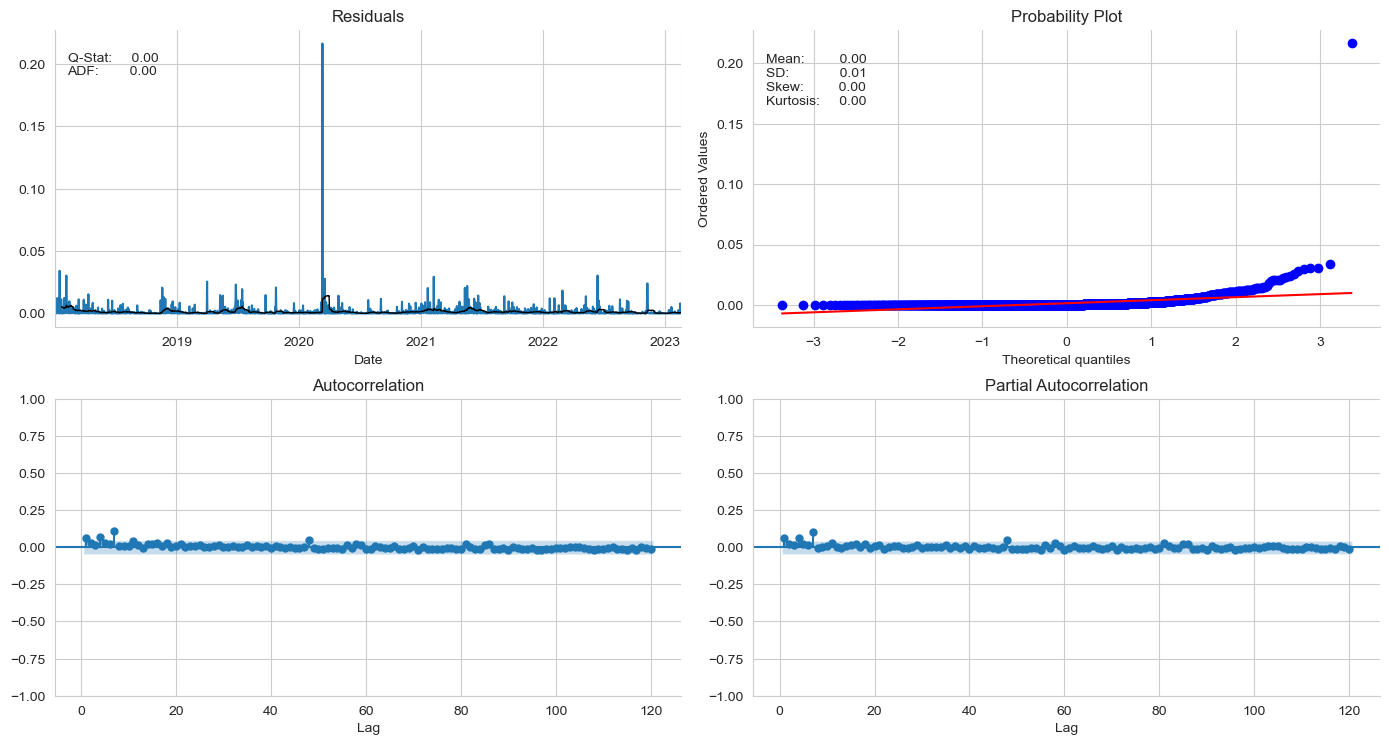

In [6]:
nvda_daily_vol = (nvda_log-nvda_log.mean())**2

plot_correlogram(x=nvda_daily_vol,
                 lags=120,
                 title=None)

In [7]:
from arch import arch_model

##### Change the number of years defends on how many years data has been used ####################
#number of year data * Working days of a year #############

trainsize = 5*365

data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

T = len(nvda_log)

results = {}

for p in range(1, 5):
    
    for q in range(1, 5):
        
        print(f'{p} | {q}')

        result = []

        for s, t in enumerate(range(trainsize, T-1)):

            train_set = data.iloc[s:t]

            test_set = data.iloc[t+1]

            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')

            forecast = model.forecast(horizon=1)

            mu = forecast.mean.iloc[-1, 0]

            var = forecast.variance.iloc[-1, 0]

            result.append([(test_set-mu)**2, var])

        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])

        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [8]:
results

{(1, 1): 0.0010121190997038761,
 (1, 2): 0.0010194920022358004,
 (1, 3): 0.0010130050925781303,
 (1, 4): 0.0010093857917084096,
 (2, 1): 0.001010281669711396,
 (2, 2): 0.001028005811583373,
 (2, 3): 0.0010186503713577198,
 (2, 4): 0.001009836742375808,
 (3, 1): 0.0010123714876151455,
 (3, 2): 0.0010220784158376532,
 (3, 3): 0.0010013167080520009,
 (3, 4): 0.0010162956490629646,
 (4, 1): 0.0010093613945633692,
 (4, 2): 0.0010365119997818814,
 (4, 3): 0.0010195554097746004,
 (4, 4): 0.0010263268139020477}

In [9]:
pd.DataFrame(results, index=pd.Series(0)).unstack().idxmin()

(3, 3, 0)

In [31]:
data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

best_model = arch_model(y=data, p=1, q=3).fit(update_freq=5, disp='off')

print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3984.77
Distribution:                  Normal   AIC:                          -7957.55
Method:            Maximum Likelihood   BIC:                          -7924.34
                                        No. Observations:                 1871
Date:                Mon, Feb 20 2023   Df Residuals:                     1870
Time:                        23:32:04   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.4284e-04  6.164e-04      1.043      0.297 

In [40]:
data = nvda_log.to_frame('nvda_log_ret')

################ Here We take last 70 working days ###########################################

data['variance'] = data['nvda_log_ret'].rolling(70).var()

################ Here, Year have to change ###########################################

data = data['2022':]

def predict_volatility(x):  
    
    ######################### Confiqure the Model with above result  ##############################################
    
    best_model = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    
    print(x.index[-1])
    
    return variance_forecast

data['predictions'] = data['nvda_log_ret'].rolling(70).apply(lambda x: predict_volatility(x))

data = data.dropna()

data

2022-03-11 00:00:00+00:00
2022-03-12 00:00:00+00:00
2022-03-13 00:00:00+00:00
2022-03-14 00:00:00+00:00
2022-03-15 00:00:00+00:00
2022-03-16 00:00:00+00:00
2022-03-17 00:00:00+00:00
2022-03-18 00:00:00+00:00
2022-03-19 00:00:00+00:00
2022-03-20 00:00:00+00:00
2022-03-21 00:00:00+00:00
2022-03-22 00:00:00+00:00
2022-03-23 00:00:00+00:00
2022-03-24 00:00:00+00:00
2022-03-25 00:00:00+00:00
2022-03-26 00:00:00+00:00
2022-03-27 00:00:00+00:00
2022-03-28 00:00:00+00:00
2022-03-29 00:00:00+00:00
2022-03-30 00:00:00+00:00
2022-03-31 00:00:00+00:00
2022-04-01 00:00:00+00:00
2022-04-02 00:00:00+00:00
2022-04-03 00:00:00+00:00
2022-04-04 00:00:00+00:00
2022-04-05 00:00:00+00:00
2022-04-06 00:00:00+00:00
2022-04-07 00:00:00+00:00
2022-04-08 00:00:00+00:00
2022-04-09 00:00:00+00:00
2022-04-10 00:00:00+00:00
2022-04-11 00:00:00+00:00
2022-04-12 00:00:00+00:00
2022-04-13 00:00:00+00:00
2022-04-14 00:00:00+00:00
2022-04-15 00:00:00+00:00
2022-04-16 00:00:00+00:00
2022-04-17 00:00:00+00:00
2022-04-18 0

C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-06-20 00:00:00+00:00
2022-06-21 00:00:00+00:00
2022-06-22 00:00:00+00:00
2022-06-23 00:00:00+00:00
2022-06-24 00:00:00+00:00
2022-06-25 00:00:00+00:00
2022-06-26 00:00:00+00:00
2022-06-27 00:00:00+00:00
2022-06-28 00:00:00+00:00
2022-06-29 00:00:00+00:00
2022-06-30 00:00:00+00:00
2022-07-01 00:00:00+00:00
2022-07-02 00:00:00+00:00
2022-07-03 00:00:00+00:00
2022-07-04 00:00:00+00:00
2022-07-05 00:00:00+00:00
2022-07-06 00:00:00+00:00
2022-07-07 00:00:00+00:00
2022-07-08 00:00:00+00:00
2022-07-09 00:00:00+00:00
2022-07-10 00:00:00+00:00
2022-07-11 00:00:00+00:00
2022-07-12 00:00:00+00:00
2022-07-13 00:00:00+00:00
2022-07-14 00:00:00+00:00
2022-07-15 00:00:00+00:00
2022-07-16 00:00:00+00:00
2022-07-17 00:00:00+00:00
2022-07-18 00:00:00+00:00
2022-07-19 00:00:00+00:00
2022-07-20 00:00:00+00:00
2022-07-21 00:00:00+00:00
2022-07-22 00:00:00+00:00
2022-07-23 00:00:00+00:00
2022-07-24 00:00:00+00:00
2022-07-25 00:00:00+00:00
2022-07-26 00:00:00+00:00
2022-07-27 00:00:00+00:00
2022-07-28 0

C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2023-01-29 00:00:00+00:00
2023-01-30 00:00:00+00:00
2023-01-31 00:00:00+00:00
2023-02-01 00:00:00+00:00
2023-02-02 00:00:00+00:00
2023-02-03 00:00:00+00:00
2023-02-04 00:00:00+00:00
2023-02-05 00:00:00+00:00
2023-02-06 00:00:00+00:00
2023-02-07 00:00:00+00:00
2023-02-08 00:00:00+00:00
2023-02-09 00:00:00+00:00
2023-02-10 00:00:00+00:00
2023-02-11 00:00:00+00:00
2023-02-12 00:00:00+00:00
2023-02-13 00:00:00+00:00
2023-02-14 00:00:00+00:00
2023-02-15 00:00:00+00:00


,nvda_log_ret,variance,predictions
Date,,,
2022-03-11 00:00:00+00:00,-0.016425,0.001409,0.002025
2022-03-12 00:00:00+00:00,0.002807,0.001395,0.001993
2022-03-13 00:00:00+00:00,-0.027475,0.001403,0.001962
2022-03-14 00:00:00+00:00,0.046891,0.001435,0.001995
2022-03-15 00:00:00+00:00,-0.008302,0.001434,0.001931
...,...,...,...
2023-02-11 00:00:00+00:00,0.010096,0.000421,0.000220
2023-02-12 00:00:00+00:00,-0.003787,0.000421,0.000248
2023-02-13 00:00:00+00:00,0.000913,0.000418,0.000257


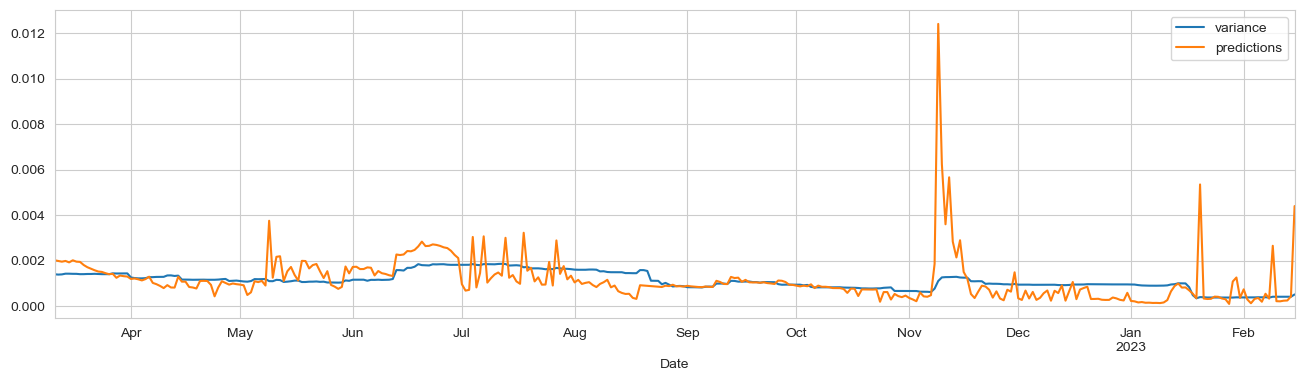

In [41]:
data[['variance', 'predictions']].plot(figsize=(16,4))

plt.show()

In [42]:
from pykalman import KalmanFilter

def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

data['fixed_predictions'] = KalmanFilterAverage(data['predictions'])

data

,nvda_log_ret,variance,predictions,fixed_predictions
Date,,,,
2022-03-11 00:00:00+00:00,-0.016425,0.001409,0.002025,0.001012
2022-03-12 00:00:00+00:00,0.002807,0.001395,0.001993,0.001344
2022-03-13 00:00:00+00:00,-0.027475,0.001403,0.001962,0.001503
2022-03-14 00:00:00+00:00,0.046891,0.001435,0.001995,0.001607
2022-03-15 00:00:00+00:00,-0.008302,0.001434,0.001931,0.001666
...,...,...,...,...
2023-02-11 00:00:00+00:00,0.010096,0.000421,0.000220,0.000623
2023-02-12 00:00:00+00:00,-0.003787,0.000421,0.000248,0.000587
2023-02-13 00:00:00+00:00,0.000913,0.000418,0.000257,0.000556


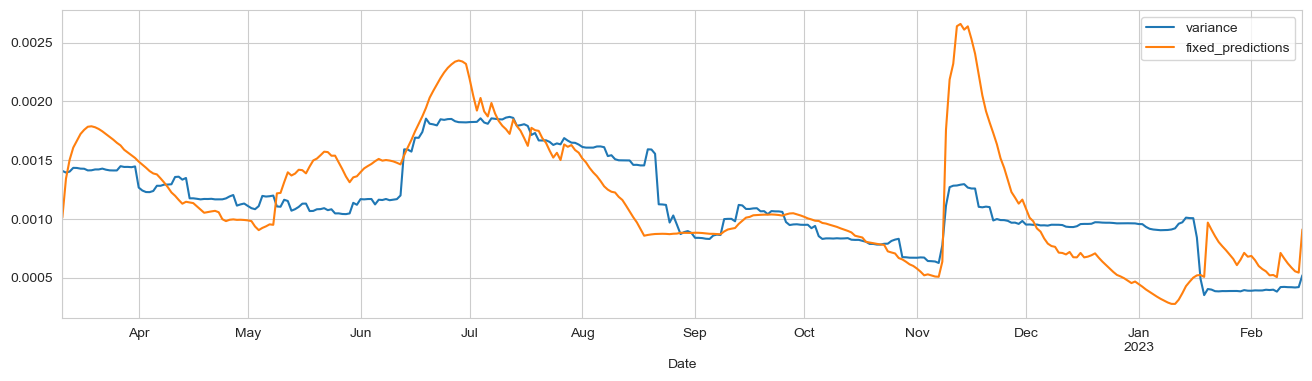

In [43]:
data[['variance', 'fixed_predictions']].plot(figsize=(16,4))

plt.show()

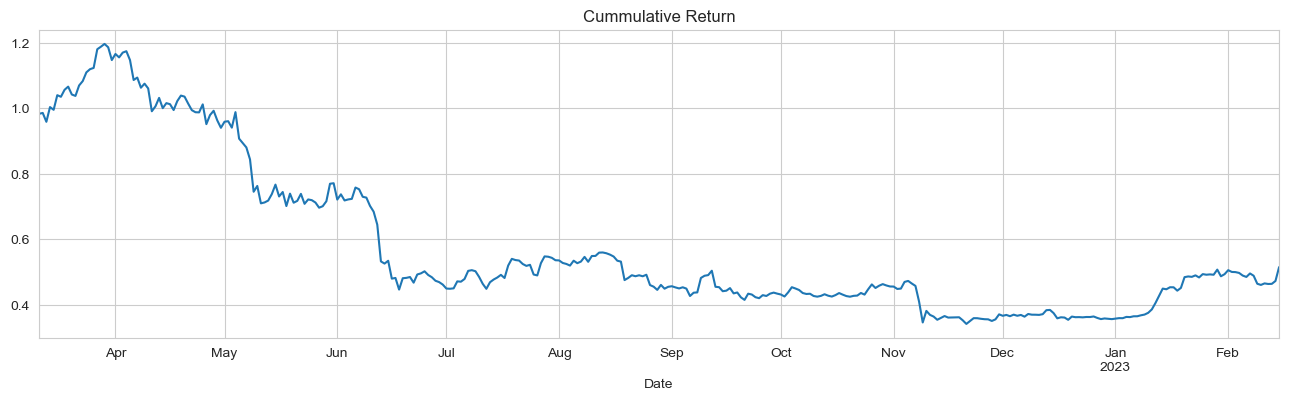

In [44]:
np.exp(np.log1p(data['nvda_log_ret']).cumsum()).plot(figsize=(16,4))

plt.title('Cummulative Return')

plt.show()

In [45]:
print(f"Sharpe Ratio : {(data['nvda_log_ret'].mean()/data['nvda_log_ret'].std())*(200**.5)}")

Sharpe Ratio : -0.6261248091366849


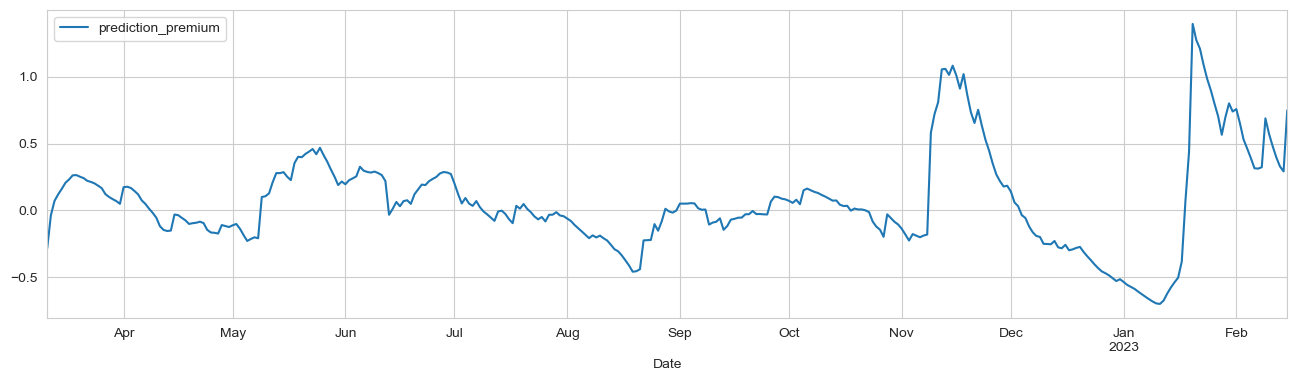

In [46]:
data['prediction_premium'] = (data['fixed_predictions']-data['variance'])/data['variance']

data[['prediction_premium']].plot(figsize=(16,4))

plt.show()

In [51]:
data['premium_diff'] = data['prediction_premium'].diff()

std = data['prediction_premium'].diff().std()

data['signal'] = data.apply(lambda x: 1 if (x['prediction_premium']<0)&(x['premium_diff']>std)
                            else (-1 if (x['prediction_premium']>0)&(x['premium_diff']<-std) else np.nan), axis=1)

data['signal'] = data['signal'].ffill(limit=5)

data['strategy_return'] = (data['nvda_log_ret']*data['signal'])

data

,nvda_log_ret,variance,predictions,fixed_predictions,prediction_premium,premium_diff,signal,strategy_return
Date,,,,,,,,
2022-03-11 00:00:00+00:00,-0.016425,0.001409,0.002025,0.001012,-0.281661,NaN,NaN,NaN
2022-03-12 00:00:00+00:00,0.002807,0.001395,0.001993,0.001344,-0.036678,0.244983,1.0,0.002807
2022-03-13 00:00:00+00:00,-0.027475,0.001403,0.001962,0.001503,0.071350,0.108028,1.0,-0.027475
2022-03-14 00:00:00+00:00,0.046891,0.001435,0.001995,0.001607,0.119922,0.048571,1.0,0.046891
2022-03-15 00:00:00+00:00,-0.008302,0.001434,0.001931,0.001666,0.161554,0.041633,1.0,-0.008302
...,...,...,...,...,...,...,...,...
2023-02-11 00:00:00+00:00,0.010096,0.000421,0.000220,0.000623,0.479827,-0.092240,-1.0,-0.010096
2023-02-12 00:00:00+00:00,-0.003787,0.000421,0.000248,0.000587,0.396876,-0.082951,-1.0,0.003787
2023-02-13 00:00:00+00:00,0.000913,0.000418,0.000257,0.000556,0.329047,-0.067829,-1.0,-0.000913


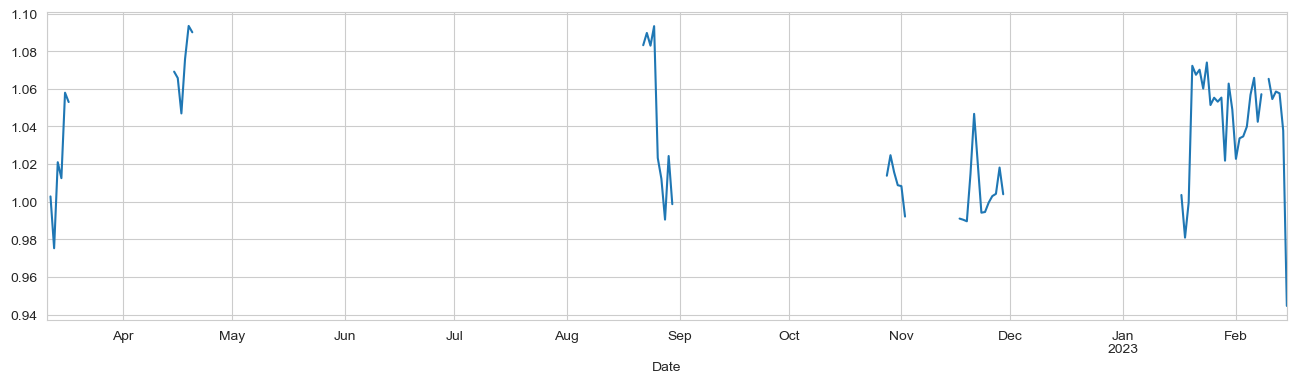

In [48]:
np.exp(np.log1p(data['strategy_return']).cumsum()).plot(figsize=(16,4))

plt.show()

In [49]:
print(f"Strategy Sharpe Ratio : {(data['strategy_return'].mean()/data['strategy_return'].std()) * (200**.5)}")

Strategy Sharpe Ratio : -0.33264636189276114
